# (dev) processing pipeline 

testing new implementation of clipping/cpt process
- central idea: separate the code more, recombine here.  

In [1]:
import os
import sys 

import numpy as np
import matplotlib.pyplot as plt


# 26.2.20 note: currently erring on the side of too many modules -- 
#               easier to consolidate later than to untangle dependencies. 
import data_utils as du
import pause_handling as ph
import apply_artifact_vec as art
import clip_to_cont as clip 
import cpt as cpt 

In [2]:
# run for interacting with database from ssh tunnel
import sys

sys.path.append("/home/tamara/Documents/DeepHumanVision_pilot/")
from data_base.db_setup import *

Please enter DataJoint username:  alana
Please enter DataJoint password:  ···············


Connecting alana@localhost:3306


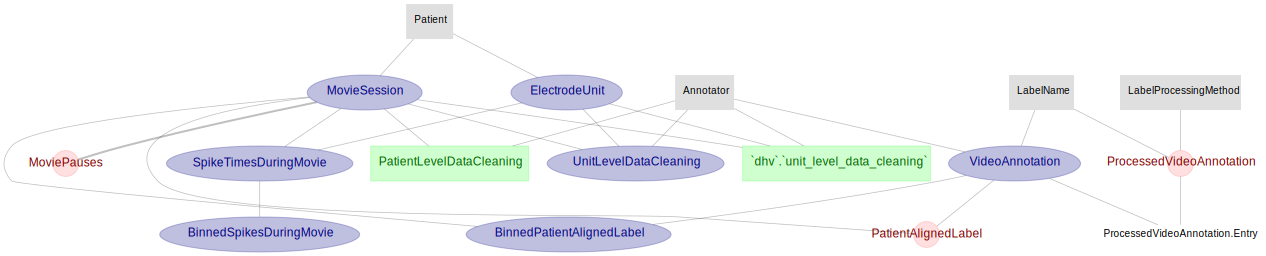

In [3]:
dj.ERD(dhv_schema)

In [4]:
BinnedSpikesDuringMovie()

patient_id patient ID,unit_id unique ID for unit (for respective patient),session_nr session ID,bin_size size of bin in ms,spike_vector in case bin_size is not 0: number of spikes; otherwise: times of spikes (original data)
46,0,1,100,=BLOB=
46,0,1,400,=BLOB=
46,0,1,1000,=BLOB=
46,1,1,100,=BLOB=
46,1,1,400,=BLOB=
46,1,1,1000,=BLOB=
46,2,1,100,=BLOB=
46,2,1,400,=BLOB=
46,2,1,1000,=BLOB=
46,3,1,100,=BLOB=


### Load in example unit
Note: for using analysis, would loop over the desired units for a given patient. 

In [5]:
test_name = (SpikeTimesDuringMovie & 'patient_id=46' & "unit_id=10" & "session_nr=1").fetch("spike_times")[0]
print(test_name)
test_unit = np.load(test_name)

os.remove(test_name)

CSC10_MUA2.npy


### Load in necessary patient meta-data 
Note: @Tamara -- are these in the database already? 

In [7]:
# load timing related patient files (different than the actual spiking data)
path_wl = ('/home/alana/DeepHumanVision_pilot/data_preprocessing/patient_data/46/ffplay-watchlog-20151212-193220.log')

path_events = '/home/tamara/Documents/DeepHumanVision_pilot/data_base/data/patient_data/46/event_file/Events.nev'

path_daqlog = '/home/alana/DeepHumanVision_pilot/data_preprocessing/patient_data/46/timedDAQ-log-20151212-193106.log'

In [8]:
# get pause values for the patient
TimeClass = du.TimeConversion(path_wl, path_daqlog, path_events)
start, stop = TimeClass.convert_pauses()

Min Daq Diff: 1.1 ms, Max Daq Diff: 5.0 ms
Maximum Error after Event fit: 1.9 ms


### Retrieve/generate pts (presentation time stamps) and rectimes (cpu time for neural/movie events) & bin 

In [10]:
# get global recording time values for the on/off-set of the movie
pts, rectime_usec = TimeClass.convert()
rectime = du.make_msec(rectime_usec)

rec_on = rectime[0]
rec_off = rectime[-1]

# make bins
bins = 1000 # define bin size in msec

total_msec = rec_off - rec_on 
total_bins = int(total_msec / bins)
bins = np.linspace(rec_on, rec_off, total_bins)

Min Daq Diff: 1.1 ms, Max Daq Diff: 5.0 ms
Maximum Error after Event fit: 1.9 ms


In [11]:
# remove the pauses from the binning edges 
bins_no_pauses, pause_indices = ph.rm_pauses_bins(bins, start, stop, return_intervals=True)

In [12]:
bins_no_pauses

array([22791043.3345    , 22792043.54614523, 22793043.75779045, ...,
       28413232.99231432, 28414233.20395955, 28415233.41560477])

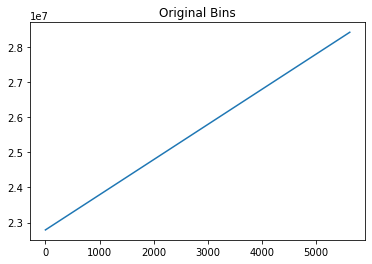

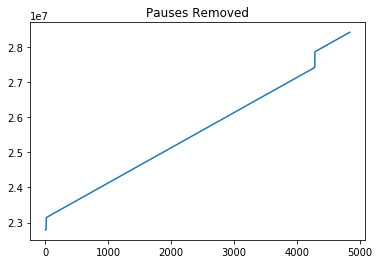

In [13]:
plt.plot(bins)
plt.title("Original Bins")
plt.show()

plt.plot(bins_no_pauses)
plt.title("Pauses Removed")
plt.show()

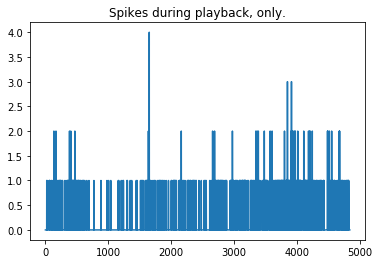

In [14]:
test_unit_no_pauses = ph.rm_pauses_spikes(test_unit, start, stop)
binary_binned, _ = np.histogram(test_unit_no_pauses, bins=bins_no_pauses)

plt.plot(binary_binned)
plt.title("Spikes during playback, only.")
plt.show()

In [15]:
PatientLevelDataCleaning()

session_nr session ID,patient_id patient ID,name unique name for data cleaning,annotator_id unique ID for each annotator,data actual data,description description of data cleaning
1,46,4stddev,p5,=BLOB=,indicating bins where sum of all spikes is higher than 4 std devs from mean
1,46,continuous,p1,=BLOB=,
1,46,continuous_pts,p5,=BLOB=,continuous watching regarding pts of movie
1,50,4stddev,p5,=BLOB=,continuous watch regarding pts of movie (after data cleaning)
1,50,continuous_pts,p5,=BLOB=,continuous watch regarding pts of movie


### Load in artifact-cleaning vectors
Note: this area is the most likely to change out of the entire pipeline

In [35]:
#load artifact related cleaning vectors
bin_arts   = np.load("binaries/46/1000/indicators/vector_artefacts_binned1000.npy")


cont_watch_name = (PatientLevelDataCleaning & 'patient_id=46' & "name='continuous_pts'"
                  & "annotator_id='p5'").fetch("data")[0]
cont_watch = np.load(cont_watch_name)
os.remove(cont_watch_name)


print("Original continuous watch vector:", len(cont_watch))

Original continuous watch vector: 5624


/home/alana/miniconda2/envs/dhv/lib/python3.8/site-packages/datajoint/connection.py:215: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


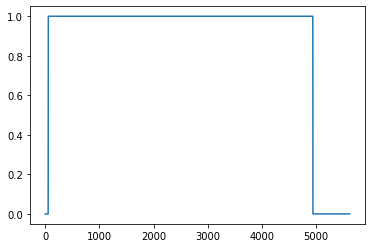

In [18]:
plt.plot(cont_watch)

In [17]:
# remove pauses from the continuous watch bin
if pause_indices[-1] == len(cont_watch):
    last = pause_indices.pop()
    pause_indices.append(last - 1)

cont_watch_no_pauses = np.delete(cont_watch, pause_indices)

In [36]:
assert len(cont_watch_no_pauses) == len(binary_binned)

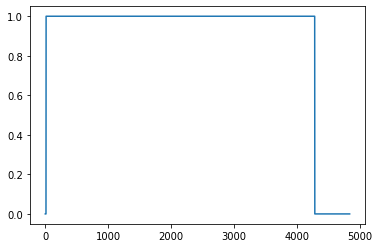

In [27]:
plt.plot(cont_watch_no_pauses)

In [34]:
### Currently, in flux. Working on bin-level artifact removal. 

## apply bin-removal artifact procedure 
# ind_art = art.get_art_ind(bin_arts)[0]
# unit_no_art = art.remove_art_from_array(test_unit, ind_art)
# cont_watch_no_art = art.remove_art_from_array(cont_watch, ind_art)

## apply cont-watch clipping  
#unit_clipped = clip.clip_array(unit_no_art, cont_watch_no_art)[0]

## Change point detection -  comparing "raw" binned activity to "cleaned" 

tau:  3478
mean pre-tau:  0.07648073605520414
std  pre-tau:  0.2855823042559116
mean post-tau:  0.16299559471365638
std  post-tau: 0.4230986474482247

T-tests:
2tail, pre- to post-tau 3.0753385581486934e-16
2tail, pre- to post-tau -8.19902588408013



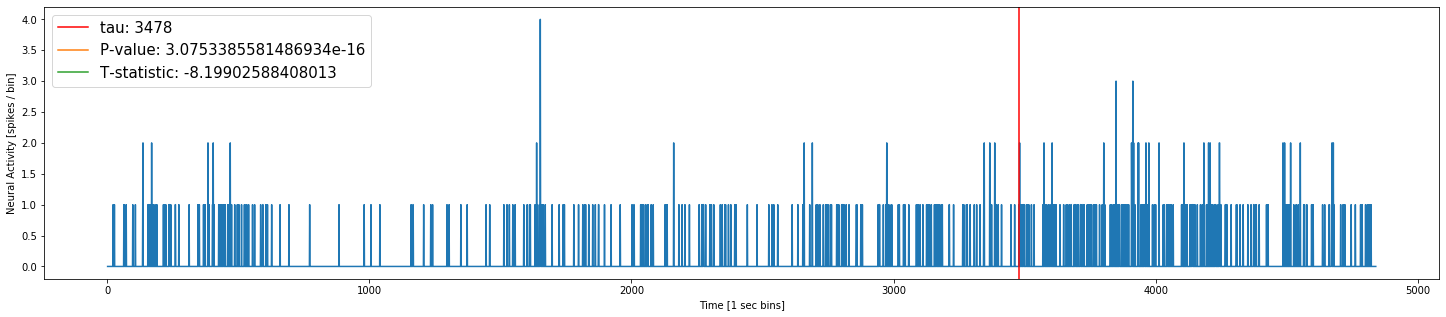

(3478,
 Ttest_indResult(statistic=-8.19902588408013, pvalue=3.0753385581486934e-16))

In [37]:
cpt.find_changepoint_tt(binary_binned)

tau:  3466
mean pre-tau:  0.07674552798615118
std  pre-tau:  0.2860407292247776
mean post-tau:  0.20099255583126552
std  post-tau: 0.4665474344902648

T-tests:
2tail, pre- to post-tau 5.395872524024868e-22
2tail, pre- to post-tau -9.693703359908142



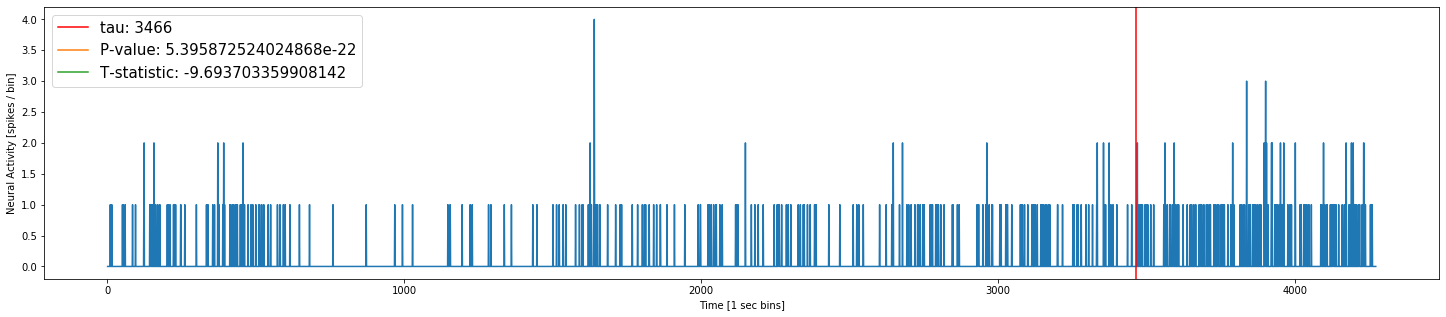

(3466,
 Ttest_indResult(statistic=-9.693703359908142, pvalue=5.395872524024868e-22))

In [38]:
unit_cw_np = clip.clip_array(binary_binned, cont_watch_no_pauses)[0]

cpt.find_changepoint_tt(unit_cw_np)